# Predict quality of Stack Overflow questions

* Sylvie Fan
* For this project, I will try to classify into three classes:
    * must be closed
    * must be edited
    * high-quality
* Based on results of several models, the model achieved 92.65% accuracy.

# Import all libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

import re
from tqdm import tqdm

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem.snowball import SnowballStemmer

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, f1_score
import scipy.sparse as sp
import pyrsm as rsm
from sklearn.metrics import plot_confusion_matrix

In [2]:
pd.set_option("display.max_rows", None) 
  

# 1. EDA

In [3]:
## Analysis Of Tags

In [4]:
data1 = pd.read_csv("train.csv")


labels = ['Open Questions', 'Low Quality Question - Close', 'Low Quality Question - Edit']
values = [len(data1[data1['Y'] == 2]), len(data1[data1['Y'] == 0]), len(data1[data1['Y'] == 1])]
plt.figure(figsize=(16, 9))
plt.pie(x=values, labels=labels, autopct="%1.1f%%")
plt.title("Label Distribution")
plt.show()

In [5]:
def replace_punct(text):
    text = text.replace("><",",")
    text = text.replace("<","")
    text = text.replace(">","")
    return text

data1['Tags_cleaned'] = data1['Tags'].apply(replace_punct)

In [6]:
def tags_explore(tagname):
    index = data1['Tags_cleaned'].str.contains(tagname)
    cdf = data1.loc[index,:]
    return cdf.Y.value_counts()

In [7]:
tags_to_row = {}
for i, row in enumerate(data1['Tags_cleaned'].tolist()):
    for tag in row.split(","):
        if tag in tags_to_row:
            tags_to_row[tag].append(i)
        else:
            tags_to_row[tag] = [i]
tags_to_Y  = {tag: data1.loc[row_indices, 'Y'].value_counts() for tag, row_indices in tags_to_row.items()}

tag_df = pd.DataFrame(tags_to_Y).T


In [8]:
filter_tagdf = tag_df.loc[tag_df.sum(axis=1) >= 1000,:]
filter_tagdf['total'] = filter_tagdf.sum(axis=1)
filter_tagdf['HQratio'] = filter_tagdf['HQ'] / filter_tagdf['total']

<ipython-input-8-6f3c9b443d33>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_tagdf['total'] = filter_tagdf.sum(axis=1)
<ipython-input-8-6f3c9b443d33>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_tagdf['HQratio'] = filter_tagdf['HQ'] / filter_tagdf['total']


<AxesSubplot:>

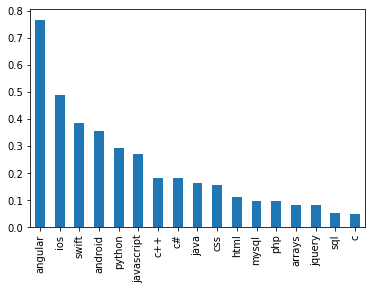

In [9]:
filter_tagdf['HQratio'].sort_values()[::-1].plot.bar()

In [10]:
data1.CreationDate = data1.CreationDate.astype('datetime64[ns]')
data1['year'] = data1.CreationDate.dt.year

<AxesSubplot:xlabel='year', ylabel='count'>

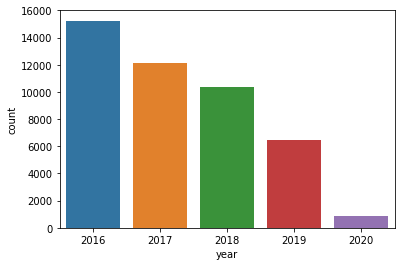

In [11]:
import seaborn as sns
sns.countplot(x = 'year', data = data1)

In [12]:
data1.groupby('Y')['Id'].count()

Y
HQ          15000
LQ_CLOSE    15000
LQ_EDIT     15000
Name: Id, dtype: int64

In [13]:
test = pd.read_csv("valid.csv")

In [14]:
test.groupby('Y')['Id'].count()

Y
HQ          5000
LQ_CLOSE    5000
LQ_EDIT     5000
Name: Id, dtype: int64

In [15]:
data1['Y'] = data1['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})

# 2. Make features with Title + Body

In [16]:
data2 = data1.drop(['Tags', 'CreationDate','Tags_cleaned'], axis=1)
data2['Body_with_title'] = data2['Title'] + " " + data2['Body']

In [17]:
xtrain, xvalid, ytrain, yvalid = train_test_split(data2.drop(['Id','Title','Body','Y','year'],axis=1).values, data2['Y'].values, 
                                                  stratify=data2['Y'].values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [18]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')


In [19]:
tfv.fit(list(xtrain[:,-1]))
xtrain_tfv =  tfv.transform(xtrain[:,-1]) 
xvalid_tfv = tfv.transform(xvalid[:,-1])

## Fit a simple Logistic regression Model 

In [20]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(max_iter=1000)
clf.fit(xtrain_tfv, ytrain)
predictions_tfv = clf.predict(xvalid_tfv)

In [21]:
multilabel_confusion_matrix(yvalid, predictions_tfv)

array([[[5636,  364],
        [ 355, 2645]],

       [[5958,   42],
        [  21, 2979]],

       [[5678,  322],
        [ 352, 2648]]])

In [22]:
body_title_accuracy = accuracy_score(y_pred=predictions_tfv, y_true=yvalid)
body_title_f1macro = f1_score(y_pred=predictions_tfv, y_true=yvalid, average="macro")
body_title_f1micro = f1_score(y_pred=predictions_tfv, y_true=yvalid, average="micro")
print(body_title_accuracy)
print(body_title_f1macro)
print(body_title_f1micro)

0.9191111111111111
0.9189949822745181
0.9191111111111111


# 3. Make features with Title + Body + Tags

In [23]:
xtrain, xvalid, ytrain, yvalid = train_test_split(data1['Tags_cleaned'].values, data1['Y'].values, 
                                                  stratify=data1['Y'].values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [24]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(xtrain)
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [25]:
xtrain_ctv.shape

(36000, 65307)

In [26]:
# combine the matrix of body title and tags
X_train = sp.hstack([xtrain_tfv, xtrain_ctv])
X_valid = sp.hstack([xvalid_tfv, xvalid_ctv])

## Fit a simple Logistic regression Model 

In [27]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, ytrain)
predictions_body_tag = clf.predict(X_valid)

In [28]:
body_tag_accuracy = accuracy_score(y_pred=predictions_body_tag, y_true=yvalid)
body_tag_f1_macro = f1_score(y_pred=predictions_body_tag, y_true=yvalid, average="macro")
body_tag_f1_micro = f1_score(y_pred=predictions_body_tag, y_true=yvalid, average="micro")
print(body_tag_accuracy)
print(body_tag_f1_macro)

print(body_tag_f1_micro)

0.9217777777777778
0.9217200360809877
0.9217777777777778


# best model valid on test data

In [29]:
test['Tags_cleaned'] = test['Tags'].apply(replace_punct)
test['Y'] = test['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})
test['Body_with_title'] = test['Title'] + " " + test['Body']

In [30]:
X_test1 = test.drop(['Id','Title','Body','Y'],axis=1).values
X_tfv = tfv.transform(X_test1[:,-1])

In [31]:
X_test2 = test['Tags_cleaned'].values
X_ctv = ctv.transform(X_test2)

In [32]:
X_test = sp.hstack([X_tfv, X_ctv])
y_test = test['Y'].values

In [33]:
predictions_final = clf.predict(X_test)

In [34]:
final_accuracy = accuracy_score(y_pred=predictions_final, y_true=y_test)
final_f1_macro = f1_score(y_pred=predictions_final, y_true=y_test, average="macro")
final_f1_micro = f1_score(y_pred=predictions_final, y_true=y_test, average="micro")
print(final_accuracy)
print(final_f1_macro)
print(final_f1_micro)

0.9166
0.9165637063363198
0.9166


# 4. Making other features: Difference in Number of title and body

In [35]:
data1['Num_words_body'] = data1['Body'].apply(lambda x:len(str(x).split())) #Number Of words in body
data1['Num_words_title'] = data1['Title'].apply(lambda x:len(str(x).split())) #Number Of words in title
data1['difference_in_words'] = abs(data1['Num_words_body'] - data1['Num_words_title'])

In [36]:
xtrain_diff = data1[['difference_in_words']]

In [37]:
test['Num_words_body'] = test['Body'].apply(lambda x:len(str(x).split())) #Number Of words in body
test['Num_words_title'] = test['Title'].apply(lambda x:len(str(x).split())) #Number Of words in title
test['difference_in_words'] = abs(test['Num_words_body'] - test['Num_words_title'])
xtest_diff = test[['difference_in_words']]

In [38]:
dataset = pd.concat(objs = [xtrain_diff, xtest_diff], axis = 0)
train_objs_num = len(xtrain_diff)
dataset_diff= pd.get_dummies(dataset, columns = ['difference_in_words'], sparse = True)
xtrain_diff = dataset_diff[:train_objs_num]
xtest_diff = dataset_diff[train_objs_num:]

In [39]:
xtrain_diff, xvalid_diff, ytrain, yvalid = train_test_split(xtrain_diff.values, data1['Y'].values, 
                                                  stratify=data1['Y'].values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [40]:
X_train = sp.hstack([xtrain_tfv, xtrain_ctv, xtrain_diff])

In [41]:
X_valid = sp.hstack([xvalid_tfv, xvalid_ctv, xvalid_diff])

## Fit a simple Logistic regression Model 

In [42]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, ytrain)

LogisticRegression(max_iter=1000)

In [43]:
predictions_diff = clf.predict(X_valid)

In [44]:
diff_accuracy = accuracy_score(y_pred=predictions_diff, y_true=yvalid)
diff_f1_macro = f1_score(y_pred=predictions_diff, y_true=yvalid, average="macro")
diff_f1_micro = f1_score(y_pred=predictions_diff, y_true=yvalid, average="micro")
print(diff_accuracy)
print(diff_f1_macro)

print(diff_f1_micro)

0.9191111111111111
0.9191054446362458
0.9191111111111111


## best model valid on test data

In [45]:
X_test = sp.hstack([X_tfv, X_ctv, xtest_diff])


In [46]:
predictions_final = clf.predict(X_test)

In [47]:
final_accuracy = accuracy_score(y_pred=predictions_final, y_true=y_test)
final_f1_macro = f1_score(y_pred=predictions_final, y_true=y_test, average="macro")
final_f1_micro = f1_score(y_pred=predictions_final, y_true=y_test, average="micro")
print(final_accuracy)
print(final_f1_macro)
print(final_f1_micro)

0.914
0.9138969508767861
0.914


# 5. Making fuzz features

In [48]:
from fuzzywuzzy import fuzz
data1['fuzz_partial_ratio'] = data1.apply(lambda x:fuzz.partial_ratio(str(x['Title']),str(x['Body'])), axis=1) 

/usr/local/lib/python3.8/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [49]:
test['fuzz_partial_ratio'] = test.apply(lambda x:fuzz.partial_ratio(str(x['Title']),str(x['Body'])), axis=1) 

In [50]:
xtrain_fuzz = data1[['fuzz_partial_ratio']]
xtest_fuzz = test[['fuzz_partial_ratio']]

In [51]:
dataset = pd.concat(objs = [xtrain_fuzz, xtest_fuzz], axis = 0)
train_objs_num = len(xtrain_fuzz)
dataset_fuzz = pd.get_dummies(dataset, columns = ['fuzz_partial_ratio'], sparse = True)
xtrain_fuzz = dataset_fuzz[:train_objs_num]
xtest_fuzz = dataset_fuzz[train_objs_num:]

In [52]:
xtrain_fuzz, xvalid_fuzz, ytrain, yvalid = train_test_split(xtrain_fuzz.values, data1['Y'].values, 
                                                  stratify=data1['Y'].values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [53]:
X_train = sp.hstack([xtrain_tfv, xtrain_ctv, xtrain_fuzz])
X_train.shape

(36000, 290024)

In [54]:
X_valid = sp.hstack([xvalid_tfv, xvalid_ctv, xvalid_fuzz])
X_valid.shape

(9000, 290024)

## Fit a simple Logistic regression Model 

In [55]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, ytrain)
predictions_fuzz = clf.predict(X_valid)

In [56]:
fuzz_accuracy = accuracy_score(y_pred=predictions_fuzz, y_true=yvalid)
fuzz_f1_macro = f1_score(y_pred=predictions_fuzz, y_true=yvalid, average="macro")
fuzz_f1_micro = f1_score(y_pred=predictions_fuzz, y_true=yvalid, average="micro")
print(fuzz_accuracy)
print(fuzz_f1_macro)
print(fuzz_f1_micro)

0.9216666666666666
0.9216118499341762
0.9216666666666666


# best model valid on test data

In [57]:
X_test = sp.hstack([X_tfv, X_ctv, xtest_fuzz])

In [58]:
predictions_final = clf.predict(X_test)

In [59]:
final_accuracy = accuracy_score(y_pred=predictions_final, y_true=y_test)
final_f1_macro = f1_score(y_pred=predictions_final, y_true=y_test, average="macro")
final_f1_micro = f1_score(y_pred=predictions_final, y_true=y_test, average="micro")
print(final_accuracy)
print(final_f1_macro)
print(final_f1_micro)

0.9166
0.9165577990048824
0.9166


# 6. Making other features: common words

In [40]:
data1['len_common_words'] = data1.apply(lambda x:len(set(str(x['Title']).split()).intersection(set(str(x['Body']).split()))),axis=1)

In [41]:
test['len_common_words'] = test.apply(lambda x:len(set(str(x['Title']).split()).intersection(set(str(x['Body']).split()))),axis=1)

In [42]:
xtrain_comm = data1[['len_common_words']]
xtest_comm = test[['len_common_words']]

In [43]:
dataset = pd.concat(objs = [xtrain_comm, xtest_comm], axis = 0)
train_objs_num = len(xtrain_comm)
dataset_comm = pd.get_dummies(dataset, columns = ['len_common_words'], sparse = True)
xtrain_comm = dataset_comm[:train_objs_num]
xtest_comm = dataset_comm[train_objs_num:]

In [44]:
xtrain_comm, xvalid_comm, ytrain, yvalid = train_test_split(xtrain_comm.values, data1['Y'].values, 
                                                  stratify=data1['Y'].values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [45]:
X_train = sp.hstack([xtrain_tfv, xtrain_ctv, xtrain_comm])
X_train.shape

(36000, 289953)

In [46]:
X_valid = sp.hstack([xvalid_tfv, xvalid_ctv, xvalid_comm])
X_valid.shape

(9000, 289953)

## Fit a simple Logistic regression Model 

In [47]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, ytrain)
predictions_comm = clf.predict(X_valid)

In [48]:
comm_accuracy = accuracy_score(y_pred=predictions_comm, y_true=yvalid)
comm_f1_macro = f1_score(y_pred=predictions_comm, y_true=yvalid, average="macro")
comm_f1_micro = f1_score(y_pred=predictions_comm, y_true=yvalid, average="micro")
print(comm_accuracy)
print(comm_f1_macro)
print(comm_f1_micro)

0.9228888888888889
0.9228401322349349
0.9228888888888889


# best model valid on test data

In [49]:
X_test = sp.hstack([X_tfv, X_ctv, xtest_comm])

In [50]:
predictions_final = clf.predict(X_test)

In [51]:
final_accuracy = accuracy_score(y_pred=predictions_final, y_true=y_test)
final_f1_macro = f1_score(y_pred=predictions_final, y_true=y_test, average="macro")
final_f1_micro = f1_score(y_pred=predictions_final, y_true=y_test, average="micro")
print(final_accuracy)
print(final_f1_macro)
print(final_f1_micro)

0.917
0.9169684330556297
0.917


# 7. Making other features: Year

In [35]:
test.CreationDate = test.CreationDate.astype('datetime64[ns]')
test['year'] = test.CreationDate.dt.year

In [36]:
xtrain_year = data1[['year']]
xtest_year = test[['year']]

In [37]:
dataset = pd.concat(objs = [xtrain_year, xtest_year], axis = 0)
train_objs_num = len(xtrain_year)
dataset_year = pd.get_dummies(dataset, columns = ['year'], sparse = True)
xtrain_year = dataset_year[:train_objs_num]
xtest_year = dataset_year[train_objs_num:]

In [38]:
xtrain_year, xvalid_year, ytrain, yvalid = train_test_split(xtrain_year.values, data1['Y'].values, 
                                                  stratify=data1['Y'].values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [52]:
X_train = sp.hstack([xtrain_tfv, xtrain_ctv, xtrain_comm, xtrain_year])
X_train.shape

(36000, 289958)

In [53]:
X_valid = sp.hstack([xvalid_tfv, xvalid_ctv, xvalid_comm, xvalid_year])
X_valid.shape

(9000, 289958)

# Fit a simple Logistic regression Model

In [54]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, ytrain)
predictions_year= clf.predict(X_valid)

In [55]:
year_accuracy = accuracy_score(y_pred=predictions_year, y_true=yvalid)
year_f1_macro = f1_score(y_pred=predictions_year, y_true=yvalid, average="macro")
year_f1_micro = f1_score(y_pred=predictions_year, y_true=yvalid, average="micro")
print(year_accuracy)
print(year_f1_macro)
print(year_f1_micro)

0.9308888888888889
0.9308435651315891
0.9308888888888889


# best model valid on test data

In [56]:
X_test = sp.hstack([X_tfv, X_ctv, xtest_comm, xtest_year])

In [57]:
predictions_final = clf.predict(X_test)

In [58]:
final_accuracy = accuracy_score(y_pred=predictions_final, y_true=y_test)
final_f1_macro = f1_score(y_pred=predictions_final, y_true=y_test, average="macro")
final_f1_micro = f1_score(y_pred=predictions_final, y_true=y_test, average="micro")
print(final_accuracy)
print(final_f1_macro)
print(final_f1_micro)

0.9264666666666667
0.9263963317301763
0.9264666666666667


In [59]:
def plot_metric(clf, testX, testY, name):
    plot_confusion_matrix(clf, testX, testY)
    plt.title(f"Confusion Matrix [{name}]")

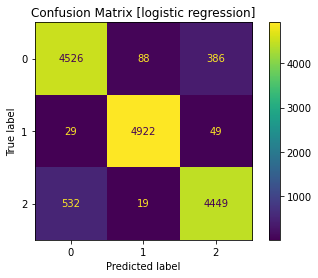

In [60]:
plot_metric(clf, X_test, y_test, 'logistic regression')

# Fit XGBoost Model

In [85]:
# XGBoost with cross-validation and grid search
clf_xgb = XGBClassifier()
param_grid = {
    "max_depth": list(range(1, 3, 1)),
    "n_estimators": list(range(10, 60, 10)),
}
scoring = {"accuracy": "accuracy"}

In [86]:
clf_cv = GridSearchCV(
    clf_xgb, param_grid, scoring=scoring, cv=5, n_jobs=8, refit='accuracy', verbose=5
).fit(X_train, ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:32:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [87]:
print(clf_cv.best_params_)
print(clf_cv.best_score_)

{'max_depth': 2, 'n_estimators': 50}
0.8948888888888888


In [88]:
clf_xgb = XGBClassifier(n_estimators = 50, max_depth = 2).fit(X_train, ytrain)

[06:32:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [89]:
predictions_xgb= clf_xgb.predict(X_valid)

In [90]:
xgb_accuracy = accuracy_score(y_pred=predictions_xgb, y_true=yvalid)
xgb_f1_macro = f1_score(y_pred=predictions_xgb, y_true=yvalid, average="macro")
xgb_f1_micro = f1_score(y_pred=predictions_xgb, y_true=yvalid, average="micro")
print(xgb_accuracy)
print(xgb_f1_macro)
print(xgb_f1_micro)

0.8916666666666667
0.8919664088574232
0.8916666666666667


# Fit KNN  Model

In [91]:
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, ytrain)

KNeighborsClassifier()

In [92]:
predictions_knn= clf_knn.predict(X_valid)

In [93]:
knn_accuracy = accuracy_score(y_pred=predictions_knn, y_true=yvalid)
knn_f1_macro = f1_score(y_pred=predictions_knn, y_true=yvalid, average="macro")
knn_f1_micro = f1_score(y_pred=predictions_knn, y_true=yvalid, average="micro")
print(knn_accuracy)
print(knn_f1_macro)
print(knn_f1_micro)

0.6077777777777778
0.6117845445861098
0.6077777777777778


# Fit SVM Model

In [94]:
svd = decomposition.TruncatedSVD(n_components=180)

In [95]:
svd = decomposition.TruncatedSVD(n_components=180)
svd.fit(X_train)
xtrain_svd = svd.transform(X_train)
xvalid_svd = svd.transform(X_valid)


In [96]:
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)

In [97]:
clf_svm = SVC(C=1.0) 
clf_svm.fit(xtrain_svd_scl, ytrain)

SVC()

In [98]:
predictions_svm = clf_svm.predict(xvalid_svd_scl)

In [99]:
svm_accuracy = accuracy_score(y_pred=predictions_svm, y_true=yvalid)
svm_f1_macro = f1_score(y_pred=predictions_svm, y_true=yvalid, average="macro")
svm_f1_micro = f1_score(y_pred=predictions_svm, y_true=yvalid, average="micro")
print(svm_accuracy)
print(svm_f1_macro)
print(svm_f1_micro)

0.7032222222222222
0.7025888024145495
0.7032222222222222


# Fit NB Model

In [100]:
clf_nb = MultinomialNB()
clf_nb.fit(X_train, ytrain)

MultinomialNB()

In [101]:
predictions_nb = clf_nb.predict(X_valid)

In [102]:
nb_accuracy = accuracy_score(y_pred=predictions_nb, y_true=yvalid)
nb_f1_macro = f1_score(y_pred=predictions_nb, y_true=yvalid, average="macro")
nb_f1_micro = f1_score(y_pred=predictions_nb, y_true=yvalid, average="micro")
print(nb_accuracy)
print(nb_f1_macro)
print(nb_f1_micro)

0.7978888888888889
0.7980988989296421
0.7978888888888888


# 8. Word2Vec with the original dataset


In [103]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [104]:
from collections import defaultdict
from math import log, sqrt
import numpy as np
from numpy import linalg as LA
from gensim.models import Word2Vec, LdaModel
from gensim.corpora import Dictionary

In [105]:
import nltk

nltk.download('punkt') 
nltk.download('stopwords') 

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

# create text pre-processing founction
def pre_processing(doc):
    # create initial token list
    tokens = []
    # step 1 : get sentence
    sentences = sent_tokenize(doc)
    # step 2 :  get the word from each stence
    for sent in sentences:
        words = word_tokenize(sent)      
    # step 3 :  get the lower words and remove 'stop word'
    words = [w.lower() for w in words if w not in stop]
    # step 4 :  get tokens
    tokens += words
    # step 5: remove empty tokens
    import re
    tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]
    return tokens

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [106]:
xtrain_bwt = data2['Body_with_title']
test['Body_with_title'] = test['Title'] + " " + test['Body']
xtest_bwt = test['Body_with_title']
dataset = pd.concat([xtrain_bwt,xtest_bwt], axis = 0)

In [107]:
corpus= list(dataset.apply(pre_processing))
corpus_train = list(xtrain_bwt.apply(pre_processing))
corpus_test = list(xtest_bwt.apply(pre_processing))

In [108]:
from gensim.models import word2vec
w2v = word2vec.Word2Vec(corpus, size=100, window=5)

In [109]:
def doc2vec_1(doc, model):
    vecs = []
    for token in doc:
        try:
            vecs.append(model[token])
        except KeyError:
            pass
    if len(vecs) == 0:
        return np.zeros(100)
    else:
        return np.array(np.mean(vecs, axis=0))

In [110]:
X_train = []
for doc in corpus_train:
    X_train.append(doc2vec_1(doc, w2v))

<ipython-input-109-69009ffc9ab6>:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vecs.append(model[token])


In [111]:
X_test = []
for doc in corpus_test:
    X_test.append(doc2vec_1(doc, w2v))

<ipython-input-109-69009ffc9ab6>:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vecs.append(model[token])


In [112]:
xtrain_w2v, xvalid_w2v, ytrain, yvalid = train_test_split(X_train, data1['Y'].values, 
                                                  stratify=data1['Y'].values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

# Fit a simple Logistic regression Model

In [113]:
clf.fit(xtrain_w2v, ytrain)
predictions_w2v= clf.predict(xvalid_w2v)

In [114]:
w2v_accuracy = accuracy_score(y_pred=predictions_w2v, y_true=yvalid)
w2v_f1_macro = f1_score(y_pred=predictions_w2v, y_true=yvalid, average="macro")
w2v_f1_micro = f1_score(y_pred=predictions_w2v, y_true=yvalid, average="micro")
print(w2v_accuracy)
print(w2v_f1_macro)
print(w2v_f1_micro)

0.7715555555555556
0.7695462006071764
0.7715555555555556


# best model valid on test data

In [115]:
predictions_final = clf.predict(X_test)

In [116]:
final_accuracy = accuracy_score(y_pred=predictions_final, y_true=y_test)
final_f1_macro = f1_score(y_pred=predictions_final, y_true=y_test, average="macro")
final_f1_micro = f1_score(y_pred=predictions_final, y_true=y_test, average="micro")
print(final_accuracy)
print(final_f1_macro)
print(final_f1_micro)

0.7655333333333333
0.7637028818172665
0.7655333333333333


# 9. Word2Vec with Glove

In [117]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = 'glove.6B.100d.txt'
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)

glove = KeyedVectors.load_word2vec_format(tmp_file, binary = False)

In [118]:
X_train = []
for doc in corpus_train:
    X_train.append(doc2vec_1(doc, glove))


In [119]:
X_test = []
for doc in corpus_test:
    X_test.append(doc2vec_1(doc, glove))

In [120]:
xtrain_glove, xvalid_glove, ytrain, yvalid = train_test_split(X_train, data1['Y'].values, 
                                                  stratify=data1['Y'].values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

# Fit a simple Logistic regression Model

In [121]:
clf.fit(xtrain_glove, ytrain)
predictions_glove= clf.predict(xvalid_glove)

In [122]:
glove_accuracy = accuracy_score(y_pred=predictions_glove, y_true=yvalid)
glove_f1_macro = f1_score(y_pred=predictions_glove, y_true=yvalid, average="macro")
glove_f1_micro = f1_score(y_pred=predictions_glove, y_true=yvalid, average="micro")
print(glove_accuracy)
print(glove_f1_macro)
print(glove_f1_micro)

0.7273333333333334
0.7244066938672207
0.7273333333333333


# best model valid on test data

In [123]:
predictions_final = clf.predict(X_test)

In [124]:
final_accuracy = accuracy_score(y_pred=predictions_final, y_true=y_test)
final_f1_macro = f1_score(y_pred=predictions_final, y_true=y_test, average="macro")
final_f1_micro = f1_score(y_pred=predictions_final, y_true=y_test, average="micro")
print(final_accuracy)
print(final_f1_macro)
print(final_f1_micro)

0.7192
0.7160016905531609
0.7192
